In [30]:
#coding=utf-8
import pandas as pd
import numpy as np
import time
import missingno as mn
from itertools import chain
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
# to plot inline
%matplotlib inline

# 1. Data Preprocessing

In [31]:
train = pd.read_csv('train.csv')
x = train.iloc[:,0:5]
y = train['target'].values

In [32]:
# add other information: songs.csv, song_extra.csv, members.csv
songs = pd.read_csv('songs.csv')
song_extra = pd.read_csv('song_extra_info.csv')
members = pd.read_csv('members.csv')


# preprocess the 'isrc' column in song_extra_info.csv
# country code
def isrc_to_country(isrc):
    if type(isrc) == str:
        return isrc[0:2]
    else:
        return np.nan
song_extra['song_country'] = song_extra['isrc'].apply(isrc_to_country)

# year
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
song_extra['song_year'] = song_extra['isrc'].apply(isrc_to_year)
song_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

# create a new column which shows the length of a user to be a member
# use datatime type to represent time
members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
members['expiration_date'] = pd.to_datetime(members['expiration_date'], format='%Y%m%d')
# calculate the duration
members['duration'] = members['expiration_date'] - members['registration_init_time']
# transfer data type from timedelta64[ns] to float64
members['duration'] = members['duration'].astype('timedelta64[D]')
####### del members['registration_init_time'], members['expiration_date']
members.head()

# combine x with other dataset
x = x.merge(songs, on='song_id', how='left')
x = x.merge(song_extra, on='song_id', how='left')
x = x.merge(members, on='msno', how='left')

del songs, members, song_extra

# check null value for each column
x.isnull().sum()

msno                            0
song_id                         0
source_system_tab           18371
source_screen_name         414804
source_type                 21539
song_length                   114
genre_ids                  118455
artist_name                   114
composer                  1675706
lyricist                  3178797
language                      150
song_country               577858
song_year                  577858
city                            0
bd                              0
gender                    2961479
registered_via                  0
registration_init_time          0
expiration_date                 0
duration                        0
dtype: int64

## 1.1. Handling missing values

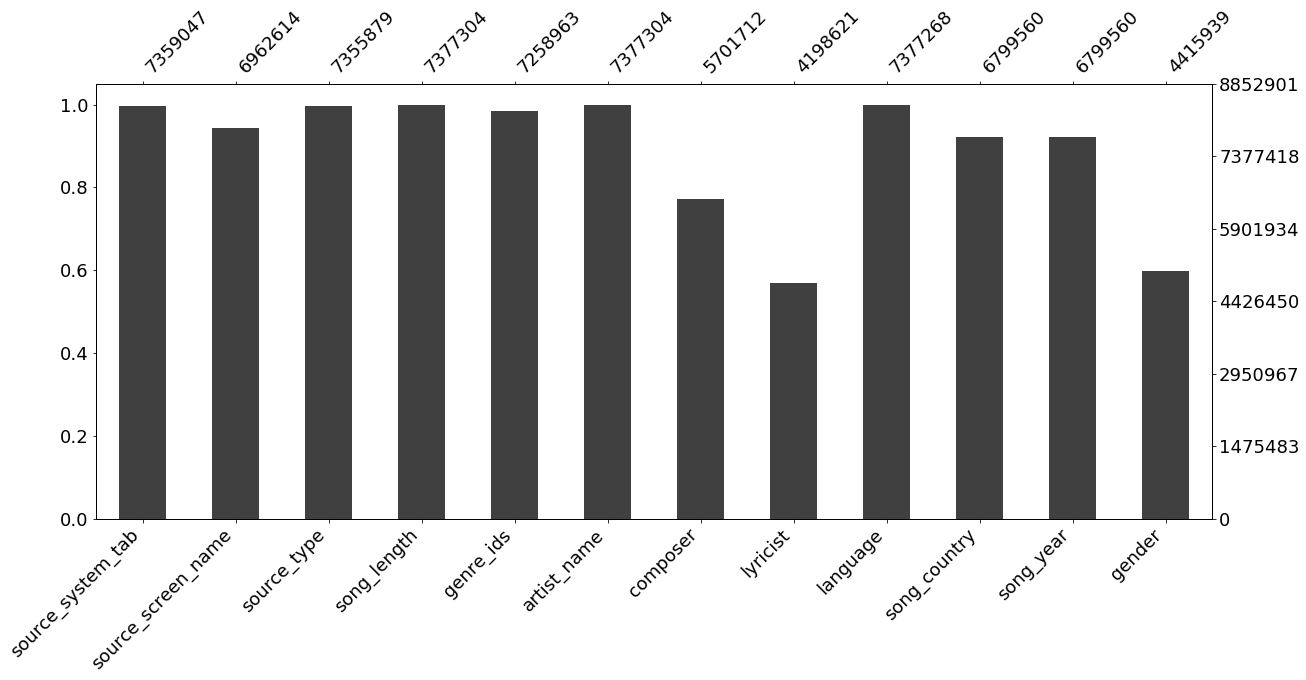

In [33]:
cols_missing_val_train = x.columns[x.isnull().any()].tolist()
mn.bar(x[cols_missing_val_train],figsize=(20,8),fontsize=18,labels=True,) #color="#32885e",

In [34]:
# Since 'bd' means age and has too much outliers, we delete directly.
print('Number of bd = 0: '+ str(x['bd'].value_counts()[0]))
print('Delete bd column...')
del x['bd']

# since composer, lyricist, gender have too much null values, we delete directly.
print('Delete composer, lyricist, gender column...')
del x['composer'], x['lyricist'], x['gender']

Number of bd = 0: 2940499
Delete bd column...
Delete composer, lyricist, gender column...


In [35]:
# # encoding: genre_ids
# genre_ids_set = set(chain.from_iterable(
#     map(lambda xx: str(xx).split('|'), x['genre_ids'].unique())))
# genre_ids_set
# x['genre_ids'] = x['genre_ids'].astype('str')
def genre_id_count(x):
    if x != np.nan:
        x = str(x)
        return x.count('|') + 1
    else:
        return 0

x['genre_ids_count'] = x['genre_ids'].apply(genre_id_count).astype(np.int8)

In [36]:
# Imputation
# for categorical variables, we replace NA values with mode of a DataFrame column
# for numerical variables, we replace NA values with mean of a DataFrame column
for column in x.columns:
    if column != 'song_length' and column != 'duration' and column != 'genre_ids_count':
        x[column] = x[column].astype('category')
        x[column].fillna(x[column].mode()[0], inplace=True)
    elif column == 'song_length':
        x[column].fillna(x[column].mean(), inplace=True)

In [37]:
x.dtypes

msno                      category
song_id                   category
source_system_tab         category
source_screen_name        category
source_type               category
song_length                float64
genre_ids                 category
artist_name               category
language                  category
song_country              category
song_year                 category
city                      category
registered_via            category
registration_init_time    category
expiration_date           category
duration                   float64
genre_ids_count               int8
dtype: object

In [38]:
# check null value again
x.isnull().any().any() # It should be False

False

## 1.2 Data Split

In [39]:
# Split data
# splitting into three sets
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.25, random_state=21)

In [40]:
# the basic rating data (3 columns)
data = pd.concat([x[['msno', 'song_id']], pd.DataFrame(y, columns=['target'])], axis=1) 

In [41]:
data.shape

(7377418, 3)

In [42]:
pd.isnull(x['genre_ids'].str.split('|').str[1]).value_counts()
# 2 or more genres are not that common. So we decided to use only the first genre as a feature

True     7037101
False     340317
Name: genre_ids, dtype: int64

In [43]:
x.columns.values

array(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'song_length', 'genre_ids', 'artist_name',
       'language', 'song_country', 'song_year', 'city', 'registered_via',
       'registration_init_time', 'expiration_date', 'duration',
       'genre_ids_count'], dtype=object)

In [44]:
x = x.drop(['source_system_tab', 'source_screen_name', 'source_type', 'song_length', 'registration_init_time', 'expiration_date', 'genre_ids_count'], axis=1)

In [45]:
### Debug
# z = x.copy(deep=True)

In [46]:
# Categorical features
x['language'] = x['language'].astype('category')
x['city'] = x['city'].astype('category')
x['registered_via'] = x['registered_via'].astype('category')

# Preprocessing
x['genre_ids'] = x['genre_ids'].str.split('|').str[0] # Use only the first genre info
# If genre is not on Top 20 genres, treat it as minor genre
non_top20_genres = x['genre_ids'].value_counts().index[20:] 
x['genre_ids'] = x['genre_ids'].replace(non_top20_genres, 1)
# If song's country is not on the top 10 countries, treat it as a minor song country
non_top10_countries = x['song_country'].value_counts().index[10:]
x['song_country'] = x['song_country'].replace(non_top10_countries, "minor")

## 1.3. Refine features 
#### Binning numerical variables [artist_name, duration, song_year]

In [47]:
# Top 100 popular artists
x['artist_name'] = x['artist_name'].str.split('|').str[0] # Use only the first artist info
# Since the artist data is quite sparse, we extract only if the artist is top 100 or not. 
top100_artists = list(x['artist_name'].value_counts().keys())[0:100]
x.loc[x['artist_name'].isin(top100_artists), 'top_art']=1
x['top_art'] = x['top_art'].fillna(0)
x['top_art'] = x['top_art'].astype(np.int32) # top_art : is a binary categorical variable of [0, 1]
del x['artist_name']

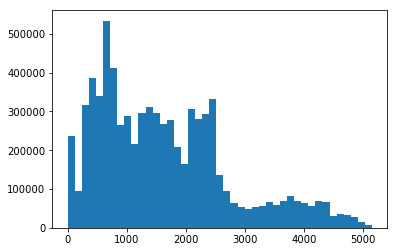

In [48]:
x.loc[x['duration']<0, 'duration'] = x['duration'].mean() # simple imputation for outliers (negative duration)
plt.hist(x['duration'], len(x['duration'].value_counts().keys())//100)
plt.show()
# We can 'bin' the duration variable as a categorical variable

In [49]:
bins = [0, 1000, 2000, 3000, x['duration'].max()]
group_names = ['VeryShort', 'Short', 'Moderate', 'Long']
x['duration_cat'] = pd.cut(x['duration'], bins, labels=group_names)
x['duration_cat'].value_counts()

VeryShort    2677124
Short        2201919
Moderate     1588338
Long          904178
Name: duration_cat, dtype: int64

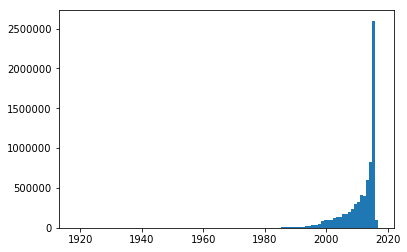

In [50]:
plt.hist(x['song_year'], 100)
plt.show()
# We can 'bin' the duration variable as a categorical variable

In [51]:
x['song_year'].value_counts().sort_index(ascending=False).head()

2017.0      97436
2016.0    2599115
2015.0     831867
2014.0     599984
2013.0     400241
Name: song_year, dtype: int64

In [52]:
bins = [x['song_year'].astype(np.float64).min(), 1990, 2000, 2010, 2015, 2016, 2017]
group_names = ['old', '90s', '2000s', '2010s', '2015', 'new']
x['song_year_cat'] = pd.cut(x['song_year'], bins, labels=group_names)
x['song_year_cat'].value_counts()

2015     2599115
2010s    2560789
2000s    1648550
90s       387166
new        97436
old        84199
Name: song_year_cat, dtype: int64

## 1.4. Make base ratings matrix
Example:

|      |item 1|item 2| ... |item n|
|:----:|:----:|:----:|:---:|:----:|
|user 1|  1   |  0   | ... |  0   |
|user 2|  0   |  0   | ... |  1   |
|  ... |  ... |  ... | ... |  ... |
|user n|  1   |  1   | ... |  0   |


In [53]:
data.columns = ['user_id', 'item_id', 'rating']
data['rating'] = data['rating']+1
data['rating'] = data['rating'].apply(np.int8)
data.shape

(7377418, 3)

In [54]:
data['rating'].value_counts()

2    3714656
1    3662762
Name: rating, dtype: int64

In [55]:
n_users = len(data.user_id.unique())
n_items = len(data.item_id.unique())
users = list(data['user_id'].unique())
items = list(data['item_id'].unique())

print(str(n_users) + ' users')
print(str(n_items) + ' items')

30755 users
359966 items


In [56]:
ratings = np.zeros((n_users, n_items), dtype=np.int8)

In [58]:
print(time.localtime(time.time()))
i=0 
for row in data.itertuples():
    user_id = users.index(row[1])
    item_id = items.index(row[2])
    rating = row[3].astype(np.int8)
    ratings[user_id, item_id] = rating # ratings[user_id, item_id] = [rating]
    i = i+1
    
print(time.localtime(time.time()))

time.struct_time(tm_year=2017, tm_mon=12, tm_mday=10, tm_hour=1, tm_min=8, tm_sec=9, tm_wday=6, tm_yday=344, tm_isdst=0)
time.struct_time(tm_year=2017, tm_mon=12, tm_mday=10, tm_hour=5, tm_min=53, tm_sec=40, tm_wday=6, tm_yday=344, tm_isdst=0)


In [91]:
from scipy.sparse import coo_matrix

In [97]:
ratings

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 2, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [59]:
import pickle
X_mat = csr_matrix(ratings)
print(time.localtime(time.time()))
f = open("X_mat_jupyter.data", 'wb')
pickle.dump(X_mat, f)
f.close() # save the sparse matrix to a file
print(time.localtime(time.time()))

time.struct_time(tm_year=2017, tm_mon=12, tm_mday=10, tm_hour=5, tm_min=56, tm_sec=1, tm_wday=6, tm_yday=344, tm_isdst=0)
time.struct_time(tm_year=2017, tm_mon=12, tm_mday=10, tm_hour=5, tm_min=56, tm_sec=1, tm_wday=6, tm_yday=344, tm_isdst=0)


## 1.5. Split data into item features and user features
** Item Features **

'genre_ids', -> replace minor genres as '1'

'artist_name' -> replace minor artists as '0', major as '1' [top_art]

'song_country', -> replace minor countries as 'minor'

'song_year', -> binning [old, 90's, ..., new] -> 'song_year_cat'

**User Features**

'duration' -> binning -> 'duration_cat'

'language',

'registered_via', 

'city'

#### These features are pulled by user id and song id for Hybrid Collaborative Filtering

In [69]:
# change user id and item id as numerical id.
# or, it won't be able to make feature matrices
print(time.localtime(time.time()))

def get_user_index(msno):
    return users.index(msno)

def get_item_index(song_id):
    return items.index(song_id)

x['user_id'] = x['msno'].apply(get_user_index)
x['item_id'] = x['song_id'].apply(get_item_index)

# for i in x.index:
#     user_id = x.iloc[i]['msno']
#     song_id = x.iloc[i]['song_id']
#     x.loc[i, 'user_id'] = users.index(user_id)
#     x.loc[i, 'item_id'] = items.index(song_id)
    
x['user_id'] = x['user_id'].astype(np.int32)
x['item_id'] = x['item_id'].astype(np.int32)

print(time.localtime(time.time()))

time.struct_time(tm_year=2017, tm_mon=12, tm_mday=10, tm_hour=16, tm_min=1, tm_sec=44, tm_wday=6, tm_yday=344, tm_isdst=0)
time.struct_time(tm_year=2017, tm_mon=12, tm_mday=10, tm_hour=16, tm_min=53, tm_sec=26, tm_wday=6, tm_yday=344, tm_isdst=0)


In [82]:
# Generate dummy variables (one-hot encoding)
# artist info should be merged later before running Hybrid CF model
item_col = ['genre_ids', 'song_country', 'song_year_cat']
user_col = ['duration_cat', 'language', 'city', 'registered_via']
item_bin = pd.get_dummies(x[item_col], prefix=['so_gen', 'so_natl', 'so_year'])
user_bin = pd.get_dummies(x[user_col], prefix=['us_dura', 'us_lang', 'us_city', 'us_rgst'])

# Now the dataframes has only binary categorical variables
# Merge this to item_id and user_id for each feature matrix

item_fmat = pd.concat([ x[['item_id', 'top_art']], item_bin ], axis=1)
user_fmat = pd.concat([ x[['user_id']], user_bin], axis=1)

X_item_features = item_fmat.drop_duplicates('item_id')
X_user_features = user_fmat.drop_duplicates('user_id')

In [83]:
print(X_item_features.shape)
print(X_user_features.shape)

(359966, 40)
(30755, 41)


In [75]:
X_item_features.to_csv('X_item_features.csv')
X_user_features.to_csv('X_user_features.csv')

In [90]:
pd.concat([x[['item_id', 'user_id']], data['rating']], axis=1).to_csv('data.csv', index=False)